In [42]:
import sys
sys.path.append("../src/") 
import os

import model_manipulation as mm
import cobra
import cplex 
import libsbml
import pandas as pd
import copy
from pathlib import Path
from tabulate import tabulate
import csv
import pytest
import matplotlib.pyplot as plt


In [9]:
#Read 2-cell model
model = cobra.io.read_sbml_model("../model/ios2164_2cell.xml")
#Estimate inf
inf = 1e6
#Set model solver
model.solver = 'gurobi'


In [10]:
#This codeblock is to define some functions that will be used for modelling.


#Define linear relationship between PPFD and Cellular maintainance costs
#This formula comes from Topfer et al (2020) where she defined NGAM in a linear relationship with incident light
def compute_ngam_atp(ppfd):
    v_atp = 0.0049*ppfd + 2.7851
    return v_atp


#This function is used to set the inputs to the model used. 
def define_model_medium(model, co2, o2, ppfd, 
                        medium_dir='../misc/photo_medium.csv', no3=inf, h2o=inf, h=inf, 
                        nh4=inf, pi=inf):
    model_photo_media = mm.read_medium_csv(medium_dir, model)
    model_photo_media['EX_no3(e)'] = no3
    model_photo_media['EX_h2o(e)'] = h2o
    model_photo_media['EX_h(e)'] = h
    model_photo_media['EX_nh4(e)'] = nh4
    model_photo_media['EX_co2(e)'] = co2
    model_photo_media['EX_o2(e)'] = o2
    model_photo_media['EX_photonVis(e)'] = ppfd
    model_photo_media['EX_pi(e)'] = pi
    #Set set model medium as model
#     print('Added model medium')
    return model_photo_media

    
def turn_off_cofac_cycles(model, inact_dir='../misc/leaf_inactivated.tsv'):
    file = csv.reader(open(inact_dir), delimiter='\t')
    leaf_inactive_rxns = list()
    for rows in file:
        row_m = str()
        row_bs = str()
        for rxns in rows:
            row_m += str(rxns) + "_M"
            row_bs += str(rxns) + "_BS"
        leaf_inactive_rxns.append(row_m)
        leaf_inactive_rxns.append(row_bs)
        
    for rxns in model.reactions:
        if rxns.id in leaf_inactive_rxns:
            rxns.bounds = (0,0)
#     print('Successfully turned off cofactor-cycling reactions')
    return leaf_inactive_rxns

    
# #Add constraints to model
#This code block contains constraints that would simulate the assimilation rates of bs and m cells in a two-cell system (such as those seen near the midvein region of rice leaves)
# #BS photon flux must be the same/less than M flux (Adapted from B&B, 2019)
# photon_import = model.reactions.get_by_id("EX_photonVis(e)")
def add_tissue_constraints(model):
    BS_photon_import = model.reactions.PRISM_white_LED_BS
    M_photon_import = model.reactions.PRISM_white_LED_M

    #Set photon flux ratio to 10:1
    photon_flux = mm.set_fix_flux_ratio({M_photon_import.id:10, BS_photon_import.id:1},model)
    model.add_cons_vars(photon_flux)

    co2tex_m = model.reactions.CO2tex_M
    co2tex_bs = model.reactions.CO2tex_BS

    #CO2 Uptake must be constrained to A (Net assimilation rate) which is around 29 +- 1.2 umol CO2 m-2 s-1 for wild type rice
    #CO2 BS intake must be limited owing to its position in the leaf tissue

    # # #CO2 intake needs to be mostly in the M cells. Not sure of the exact value:
    # # Values from Von Caemmerer (2000) in intermediate C3-C4 photosynthetic plants is 1 mmol CO2 m-2 s-1 per 20 CO2 m-2 s-1, which puts it at 20:1 ratio
    # # #try checking Danila et al. (2016) on ratio of surface area of M cell to BS cell
    # # #I'll assume that the ratio is at 20:1 in the meantime, meaning that there is minimal gas exchange into the BS cell that would equate to around ~1 umol CO2 m-2s-1
    co2_ratio_cons = mm.set_fix_flux_ratio({co2tex_m.id:10, co2tex_bs.id:1},model)
    co2_ratio_cons.name = 'co2_ratio_cons'
    model.add_cons_vars(co2_ratio_cons)

    #o2 ratio constraint
    o2tex_bs = model.reactions.O2tex_BS
    o2tex_m = model.reactions.O2tex_M

    o2_ratio_cons = mm.set_fix_flux_ratio({o2tex_m.id:10, o2tex_bs.id:1},model)
    o2_ratio_cons.name = 'o2_ratio_cons'
    model.add_cons_vars(o2_ratio_cons)

    #no tissue-specific constraints will be set for Nitrates, h2o and other inorganic cofactors as 
    #they are transported via the apoplastic pathway rather than the symplast

# #This code block contains constraints specific for enzyme rate constraints
#This approach is derived from Bogart & Myers (2016) where they constrained the enzyme rate 
#fluxes in each of the 2-cell segments to a specific upper bound while keeping the lower bound
#At 0. For reversible reactions the lower bounds are set to the same value

def add_enzyme_constraints(model):
    #Maximum values for constraints
    wt_pepc = 0 #umol m-2 s-1 #Note: Need to constrain it to 0 pala since no PEPC was detected in either cell type
    wt_mdh = 11.18 #umol m-2 s-1
    wt_nadp_me = 0.14 #umol m-2 s-1
    wt_ppdk = 0.31 #umol m-2 s-1
    wt_CA = 7.5 #umol m-2  s-1 bar-1 (Constrained to CO2 amounting to 400-500 mbar) (1 bar = 15.74 umol m-2 s-1 CA activity)

    #PEPC constraint (Reaction id: PPCc)
    #Need to constrain it to 0 since reaction is only detected in Vascular tissue
    pepc_BS = model.reactions.PPCc_BS
    pepc_M = model.reactions.PPCc_M

    wt_pepc_cons = model.problem.Constraint(pepc_BS.flux_expression 
                                            + pepc_M.flux_expression, 
                                            lb = 0, ub = wt_pepc)
    wt_pepc_cons.name = 'wt_pepc_cons'
    model.add_cons_vars(wt_pepc_cons)

    #PPDK constraints (Reaction id: PPDKs) (note that this is found in the chloroplast?) 
    #Not detected via immunolocalization but enzyme activity is detected

    ppdks_BS = model.reactions.PPDKs_BS
    ppdks_M = model.reactions.PPDKs_M
    wt_ppdks_cons = model.problem.Constraint(ppdks_BS.flux_expression 
                                             + ppdks_M.flux_expression, 
                                             lb = 0, ub = wt_ppdk)
    wt_ppdks_cons.name = 'wt_ppdks_cons'
    model.add_cons_vars(wt_ppdks_cons)
    #Malate Dehydrogenase 
    #Only mitochondrial in WT Rice M cells
    mdhm_M = model.reactions.MDHm_M


    wt_mdh_cons = model.problem.Constraint(mdhm_M.flux_expression,
                                           lb= 0, ub=wt_mdh)
    wt_mdh_cons.name = "wt_mdh_cons"
    model.add_cons_vars(wt_mdh_cons)

    #NADP-ME (Since no signal is detected in WT, no locational constraints are imposed)
    #Let's see if I can force it to have a small amount of flux 
    nadp_me_M = model.reactions.MDHys_M
    nadp_me_BS = model.reactions.MDHys_BS

    wt_nadpme_cons = model.problem.Constraint(nadp_me_M.flux_expression
                                             + nadp_me_BS.flux_expression,
                                             lb= 0, ub=wt_nadp_me)
    wt_nadpme_cons.name = "wt_nadpme_cons"
    model.add_cons_vars(wt_nadpme_cons)
    #Weird, it causes the activity of RBCL to significantly vary from the actual values


    #I should add constraints for Carbonic Anhydrase
    #I should constrain it to 0.4 ubar, which would constitute ambient CO2 partial pressure
    #Flux is reversible so constraints are bi-directional


    hco3es_m = model.reactions.HCO3Es_M.flux_expression
    hco3ec_m = model.reactions.HCO3Ec_M.flux_expression
    hco3em_m = model.reactions.HCO3Em_M.flux_expression
    hco3es_bs = model.reactions.HCO3Es_BS.flux_expression
    hco3ec_bs = model.reactions.HCO3Ec_BS.flux_expression
    hco3em_bs = model.reactions.HCO3Em_BS.flux_expression

    ca_cons = model.problem.Constraint(hco3es_m + hco3ec_m + hco3em_m 
                                       + hco3es_bs + hco3ec_bs + hco3em_bs,
                                      lb = -wt_CA, ub = wt_CA)
    ca_cons.name = 'Carbonic_anhydrase_constraint'
    model.add_cons_vars(ca_cons)
    #Rbcl constaints
    #Retrieve flux expressions oof each RBCl reaction
    rbpc_M = model.reactions.RBPCs_M.flux_expression
    rbpc_BS = model.reactions.RBPCs_BS.flux_expression
    rbpo_M = model.reactions.RBPOs_M.flux_expression
    rbpo_BS = model.reactions.RBPOs_BS.flux_expression

    #Constraint such that it is limited to 132 umol m-2 s-1
    rbcl_vcmax_cons = model.problem.Constraint(rbpc_M + rbpc_BS, lb = 0, ub= 132)
    rbcl_vcmax_cons.name='rbcl_vcmax_cons'
    model.add_cons_vars(rbcl_vcmax_cons)
    #Constraints for rbcl flux such that v_c/v_o = 3 or higher.
    rbcl_vcvo = model.problem.Constraint(3*(rbpo_M + rbpo_BS) 
                                         - 1*(rbpc_M + rbpc_BS),
                                         lb=0,ub=1000)
    rbcl_vcvo.name = 'rbcl_vc/vo_ratio'
    model.add_cons_vars(rbcl_vcvo)
    
#     rbcl_vcvo1 = model.problem.Constraint(3*(rbpo_M) 
#                                          - 1*(rbpc_M),
#                                          lb=0,ub=1000)
#     rbcl_vcvo1.name = 'rbcl_vc/vo_ratio_M'
#     model.add_cons_vars(rbcl_vcvo1)
    
# #     rbcl_vcvo2 = model.problem.Constraint(3*(rbpo_BS) 
# #                                          - 1*(rbpc_BS),
# #                                          lb=0,ub=1000)
# #     rbcl_vcvo2.name = 'rbcl_vc/vo_ratio_BS'
# #     model.add_cons_vars(rbcl_vcvo2)
    
    
    #Turn off the RBPC2s reactions since we already defined the constraints above
    model.reactions.RBPC2s_M.bounds = (0,0)
    model.reactions.RBPC2s_BS.bounds = (0,0)
    
    
    
    #What if I simply constrained that of the M cell one to 3:1?
    #This constraint is pretty good actually. 
    #This allows the system to be set at a specific Vc/Vo rate while still allowing local variation 
    #wherein Rubisco may act in an uncoupled fashion and may have favorable internal vc/vo rates.
# #This code block is to set a constraint such that M-to-BS cell NGAM ratio is 10-to-1 
# #Similar to what Moreno-Villena (2021) (preprint) had done 

#This function takes two arguments: the model and the maximal  ppfd input to the system
def add_ngam_cons(model, ppfd): 
    ngam_atp_m = mm.get_rxn(model, 'ngam_atp_c_M')
    ngam_atp_bs = mm.get_rxn(model, 'ngam_atp_c_BS')
    ngam_atp_m.bounds = (0,1000)
    ngam_atp_bs.bounds = (0,1000)
    ngam_ratio = mm.set_fix_flux_ratio({ngam_atp_m.id:10, ngam_atp_bs.id:1}, model)
    ngam_ratio.name = 'ngam_BS/M_ratio'
    model.add_cons_vars(ngam_ratio)

    #Retrieve NGAM reactions
    ngam_nadphox_c_M = mm.get_rxn(model, 'ngam_nadphox_c_M')
    ngam_nadphox_s_M = mm.get_rxn(model, 'ngam_nadphox_s_M')
    ngam_nadphox_m_M = mm.get_rxn(model, 'ngam_nadphox_m_M')
    ngam_nadphox_c_BS = mm.get_rxn(model, 'ngam_nadphox_c_BS')
    ngam_nadphox_s_BS = mm.get_rxn(model, 'ngam_nadphox_s_BS')
    ngam_nadphox_m_BS = mm.get_rxn(model, 'ngam_nadphox_m_BS')


    #Set Fixed fluxes
    nadphox_c_s_M = mm.set_fix_flux_ratio({ngam_nadphox_c_M.id:1, ngam_nadphox_s_M.id:1},model)
    nadphox_c_s_M.name = "nadphox_cs_ratio_M"
    nadphox_s_m_M = mm.set_fix_flux_ratio({ngam_nadphox_s_M.id:1, ngam_nadphox_m_M.id:1}, model)
    nadphox_s_m_M.name = "nadphox_sm_ratio_M"

    nadphox_c_s_BS = mm.set_fix_flux_ratio({ngam_nadphox_c_BS.id:1, ngam_nadphox_s_BS.id:1},model)
    nadphox_c_s_BS.name = "nadphox_cs_ratio_BS"
    nadphox_s_m_BS = mm.set_fix_flux_ratio({ngam_nadphox_s_BS.id:1, ngam_nadphox_m_BS.id:1}, model)
    nadphox_s_m_BS.name = "nadphox_sm_ratio_BS"

    #Add constraints
    model.add_cons_vars(nadphox_c_s_M)
    model.add_cons_vars(nadphox_s_m_M)
    model.add_cons_vars(nadphox_c_s_BS)
    model.add_cons_vars(nadphox_s_m_BS)

    #Retrieve flux expressionns
    fex_nadphox_c_M =  mm.get_flux_exp(model, ngam_nadphox_c_M)
    fex_nadphox_s_M = mm.get_flux_exp(model, ngam_nadphox_s_M)
    fex_nadphox_m_M = mm.get_flux_exp(model, ngam_nadphox_m_M)

    fex_nadphox_c_BS =  mm.get_flux_exp(model, ngam_nadphox_c_BS)
    fex_nadphox_s_BS =  mm.get_flux_exp(model, ngam_nadphox_s_BS)
    fex_nadphox_m_BS =  mm.get_flux_exp(model, ngam_nadphox_m_BS)

    fex_atp_c_M = mm.get_flux_exp(model, ngam_atp_m)
    fex_atp_c_BS =  mm.get_flux_exp(model, ngam_atp_bs)

    #Set the constraint between ATP:NADPH NGAM to 3:1
    nadphox_atpase = model.problem.Constraint(3*(fex_nadphox_c_M + fex_nadphox_s_M + fex_nadphox_m_M
                                                       + fex_nadphox_c_BS + fex_nadphox_s_BS + fex_nadphox_m_BS) 
                                         - 1*(fex_atp_c_M + fex_atp_c_BS),
                                         lb=0,ub=0)
    nadphox_atpase.name = "nadphox_atpase_ratio"
    model.add_cons_vars(nadphox_atpase)
    
    
    
    ngam_value = compute_ngam_atp(ppfd)
    ngam_cons = model.problem.Constraint(fex_atp_c_M + 
                                        fex_atp_c_BS, lb=ngam_value, ub=ngam_value)
    ngam_cons.name = 'NGAM_constraint'
    model.add_cons_vars(ngam_cons)
    
#This code  block gives a snapshot of the relevant fluxes on each of the cell types based on the saved sample_fluxes values above

def print_summary(sample_fluxes_df):
    print('rbcl M cell: ', sample_fluxes['RBPCs_M'], 'rbcl BS cell: ',sample_fluxes['RBPCs_BS'])
    print('rbcl M cell (photorespiration)', sample_fluxes['RBPOs_M'], 'rbcl BS cell (PR)', sample_fluxes['RBPOs_BS'])
    print('vc/vo M:', sample_fluxes['RBPCs_M']/sample_fluxes['RBPOs_M'], 'vc/vo BS:', sample_fluxes['RBPCs_BS']/sample_fluxes['RBPOs_BS'])
    print('RBPC2s_M', sample_fluxes['RBPC2s_M'], 'RBPC2s_BS', sample_fluxes['RBPC2s_BS'])
    print('PEPC M', sample_fluxes['PPCc_M'], 'PEPC BS', sample_fluxes['PPCc_BS'])
    print('Carbonic Anhydrase (Cytosolic) M', sample_fluxes['HCO3Ec_M'], 'Carbonic Anhydrase (Cytosolic) BS', sample_fluxes['HCO3Ec_BS'])
    print('NADP-ME M', sample_fluxes['MDHys_M'], 'NADP-ME BS', sample_fluxes['MDHys_BS'])
    print('Biomass M: ', sample_fluxes['Straw_Biomass_M'], 'Biomass BS', sample_fluxes['Straw_Biomass_BS'])
    print('Phloem M: ', sample_fluxes['DM_Phloem_M'], 'Phloem BS', sample_fluxes['DM_Phloem_BS'])
    print('co2 consumption M', sample_fluxes['CO2tex_M'], 'co2 consumption BS', sample_fluxes['CO2tex_BS'])
    print('o2 consumption M', sample_fluxes['O2tex_M'], 'o2 consumption BS', sample_fluxes['O2tex_BS'])
    print('Photosystem II M', sample_fluxes['PSIINC_M'], 'PSII BS', sample_fluxes['PSIINC_BS'])
    print('PSI M', sample_fluxes['PSIMR_M'], 'PSI BS', sample_fluxes['PSIMR_BS'])
    print('PPFD M: ', sample_fluxes['PRISM_white_LED_M'], 'PPFD BS: ', sample_fluxes['PRISM_white_LED_BS'])
    print('ATP synthesis (stromal) M', sample_fluxes['ATPSs_M'], 'ATP synthase (mit) M', sample_fluxes['ATPSm_M'])
    pd_rxn = [x for x in model.reactions if "pd" in x.id and "h2o" not in x.id]
    pd_abs_flux = 0
    for pds in pd_rxn:
        pd_abs_flux += abs(sample_fluxes[pds.id])
    
    print('pd_abs_flux: ', pd_abs_flux)

This code block is to add the constraints for ngam nadphox, which for some reason doesn't save when it was generated using the curation script


May 6 2022
I think I need to identify which of the reactions cause the blockage of NO3. 
I can do this by running the instance above and afterwards using the checked_blocked_reactions function to generate a list of blocked reactions.
Then afterwards I can compare it with the list of reactions with NO3 as a reactant.


In [11]:
#Let's try turning off and turning on cofac cycles 

with model as m1:

    m1.medium = define_model_medium(m1, co2=29, o2=2.216, ppfd=1000, h=inf, nh4=0, no3=inf)
#     turn_off_cofac_cycles(m1)
    add_tissue_constraints(m1)
    add_enzyme_constraints(m1)
    add_ngam_cons(m1, 1000)
    
    #Let's try turning off nga yung RBPC2s


#Constrain O2 intake to 3.312 mmol O2 gcw -1 d-1 ~~ 2.2618 umol O2 m-2 s-1 (from Lakshmanan et al. 2016)
    #Change objective function to mature leaf
    m1.reactions.get_by_id('Straw_Biomass_M').objective_coefficient = 0
    m1.reactions.get_by_id('Straw_Biomass_BS').objective_coefficient = 0
    mm.get_rxn(m1,'DM_Phloem_BS').objective_coefficient = 1
    
    
    sample_fluxes = cobra.flux_analysis.pfba(m1).fluxes
#     sample_fluxes = model.optimize().fluxes
    #Remove thermodynamically infeasible loops
    sample_fluxes = cobra.flux_analysis.loopless_solution(m1, sample_fluxes)
    blocked_rxns_w_cofac = cobra.flux_analysis.find_blocked_reactions(model)
print_summary(sample_fluxes.to_frame())

/home/rtsantos3/anaconda3/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
Could not get flux for reaction ATP2tr_M, setting it to NaN. This is usually due to numerical instability.
/home/rtsantos3/anaconda3/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
Could not get flux for reaction PGMc_BS, setting it to NaN. This is usually due to numerical instability.
/home/rtsantos3/anaconda3/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
Could not get flux for reaction ICDHm_M, setting it to NaN. This is usually due to numerical instability.
/home/rtsantos3/anaconda3/lib/python3.8/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is 

KeyboardInterrupt: 

In [ ]:
print('with cofactor-cycling reactions: ', len(blocked_rxns_w_cofac))
print('w/o cofactor-cycling reactions: ', len(blocked_rxns_no_cofac))

In [ ]:
#Blocked reactions are off

with model:
    turn_off_cofac_cycles(model)
    for item in model.metabolites.no3_c0.reactions:
        if item.id in blocked_rxns_no_cofac:
            print(item.id, item.bounds)


In [ ]:
#Blocked reactions are on
print('Blocked reactions on: ')
with model:
    for item in model.metabolites.no3_c0.reactions:
        if item.id in blocked_rxns_w_cofac:
            print(item.id, item.bounds)
print('Blocked reactions off: ')
#Blocked reactions are off
with model:
    turn_off_cofac_cycles(model)
    for item in model.metabolites.no3_c0.reactions:
        if item.id in blocked_rxns_no_cofac:
            print(item.id, item.bounds)


For NO3 (Blocked reactions):
Turned on cofactor generating cycles:
    - NO3tvr_M
Turned off cofactor generating:
    - NODOx
    - NODOy
    - NO3Rm
    - No3tex
    - NO3tvr
    - NITRc
    
Difference are the NODOx, NODOy, NO3Rm, NO3tex and NITRc

NODOx = nitric oxide NADH2 oxidoreductase 
2 no[c] + 2 o2[c] + nadh[c] -> 2 no3[c] + nad[c] + h[c]

NODOy = nitric oxide NADPH2 oxidoreductase
2 no[c] + 2 o2[c] + nadph[c] -> 2 no3[c] + nadp[c] + h[c]

NO3Rm = Nitrate reductase, mitochondrial
2 h[c] + no3[c] + q8h2[m]  -> h2o[m] + q8[m] + 2 h[c] + no2[c]

NITRc = Nitrate reductase 
no3[c] + nadh[c] + h[c] -> no2[c] + nad[c] + h2o[c]

Most of the reactions require  NADH and NADPH as their source. I wonder it is because of 
the NGAM reaction consuming most of the NADPH?


In [18]:

with model:
    turn_off_cofac_cycles(model)
    for item in model.metabolites.nh4_c0.reactions:
        if item.id in blocked_rxns_no_cofac:
            print(item.id, item.bounds)


Successfully turned off cofactor-cycling reactions
NMNDAc_M (0.0, 1000000.0)
FORAc_M (0, 0)
UREASEc_M (0, 0)
SELCYSTLc_M (0.0, 1000000.0)
PAOc_M (0.0, 1000000.0)
NADS(nh4)c_M (0.0, 1000000.0)
SELMETLs_M (-1000000.0, 1000000.0)
NTRLASEc_M (0.0, 1000000.0)
GSNDc_M (0.0, 1000000.0)
URDGLAHc_M (-1000000.0, 1000000.0)
AMID3c_M (0.0, 1000000.0)
ALTNDAc_M (0, 0)
TALc_M (0.0, 1000000.0)
CALANc_M (0, 0)
ACPCDAc_M (-1000000.0, 1000000.0)
ASNS1c_M (0, 0)
NNAMc_M (0.0, 1000000.0)
GUADc_M (0.0, 1000000.0)
GABUTAHc_M (0.0, 1000000.0)
METLc_M (-1000000.0, 1000000.0)


May 6, 2022
Results for Benchmarking Nitrogen assimilation

Set-up:
    - Medium: Autotrophic medium, NO3 as sole N source, 
    - Blocked reactions were identified using the Blocked_reactions list
    - Turned off cofactor-cycling reactions
- There wasn't any turned off reactions involving NO3 in particular. 

In [26]:
#Let's test if it is because of the NGAM constraint why the model cannot absorb any NADPH
#May 6 2022
#I think I need to identify which of the reactions cause the blockage of NO3. 
#I can do this by running the instance above and afterwards using the checked_blocked_reactions function to generate a list of blocked reactions.
#Then afterwards I can compare it with the list of reactions with NO3 as a reactant.


with model as m1:

    m1.medium = define_model_medium(m1, co2=29, o2=2.216, ppfd=200, h=inf, nh4=0, no3=inf)
    turn_off_cofac_cycles(m1)
    add_tissue_constraints(m1)
    add_enzyme_constraints(m1)
    add_ngam_cons(m1, 200)
    
    #Let's try turning off nga yung RBPC2s


#Constrain O2 intake to 3.312 mmol O2 gcw -1 d-1 ~~ 2.2618 umol O2 m-2 s-1 (from Lakshmanan et al. 2016)
    #Change objective function to mature leaf
    m1.reactions.get_by_id('Straw_Biomass_M').objective_coefficient = 0
    m1.reactions.get_by_id('Straw_Biomass_BS').objective_coefficient = 0
    mm.get_rxn(m1,'DM_Phloem_BS').objective_coefficient = 1
    
    
    sample_fluxes = cobra.flux_analysis.pfba(m1).fluxes
#     sample_fluxes = model.optimize().fluxes
    #Remove thermodynamically infeasible loops
    sample_fluxes = cobra.flux_analysis.loopless_solution(m1, sample_fluxes)
print_summary(sample_fluxes.to_frame())

Added model medium
Successfully turned off cofactor-cycling reactions
rbcl M cell:  0.0 rbcl BS cell:  0.0
rbcl M cell (photorespiration) 0.0 rbcl BS cell (PR) 0.0
vc/vo M: nan vc/vo BS: nan
RBPC2s_M 0.0 RBPC2s_BS 0.0
PEPC M 0.0 PEPC BS 0.0
Carbonic Anhydrase (Cytosolic) M 0.0 Carbonic Anhydrase (Cytosolic) BS 0.0
NADP-ME M 0.0 NADP-ME BS 0.0
Biomass M:  0.0 Biomass BS 0.0
Phloem M:  0.0 Phloem BS 0.0
co2 consumption M 0.0 co2 consumption BS 0.0
o2 consumption M 0.0 o2 consumption BS 0.0
Photosystem II M 0.0 PSII BS 0.0
PSI M 0.0 PSI BS 0.0
PPFD M:  0.0 PPFD BS:  0.0
ATP synthesis (stromal) M 0.0 ATP synthase (mit) M 0.0
pd_abs_flux:  0.0


<ipython-input-3-883c58f7d54c>:271: RuntimeWarning: invalid value encountered in double_scalars
  print('vc/vo M:', sample_fluxes['RBPCs_M']/sample_fluxes['RBPOs_M'], 'vc/vo BS:', sample_fluxes['RBPCs_BS']/sample_fluxes['RBPOs_BS'])


In [27]:
#Let's test if it is because of the NGAM constraint why the model cannot absorb any NADPH
#May 6 2022
#I think I need to identify which of the reactions cause the blockage of NO3. 
#I can do this by running the instance above and afterwards using the checked_blocked_reactions function to generate a list of blocked reactions.
#Then afterwards I can compare it with the list of reactions with NO3 as a reactant.


with model as m1:

    m1.medium = define_model_medium(m1, co2=29, o2=2.216, ppfd=1000, h=inf, nh4=inf, no3=inf)
    turn_off_cofac_cycles(m1)
    add_tissue_constraints(m1)
    add_enzyme_constraints(m1)
#     add_ngam_cons(m1, 1000)
    
    #Let's try turning off nga yung RBPC2s


#Constrain O2 intake to 3.312 mmol O2 gcw -1 d-1 ~~ 2.2618 umol O2 m-2 s-1 (from Lakshmanan et al. 2016)
    #Change objective function to mature leaf
    m1.reactions.get_by_id('Straw_Biomass_M').objective_coefficient = 0
    m1.reactions.get_by_id('Straw_Biomass_BS').objective_coefficient = 0
    mm.get_rxn(m1,'DM_Phloem_BS').objective_coefficient = 1
    
    
    sample_fluxes = cobra.flux_analysis.pfba(m1).fluxes
#     sample_fluxes = model.optimize().fluxes
    #Remove thermodynamically infeasible loops
    sample_fluxes = cobra.flux_analysis.loopless_solution(m1, sample_fluxes)
print_summary(sample_fluxes.to_frame())

Added model medium
Successfully turned off cofactor-cycling reactions
rbcl M cell:  31.93206270325328 rbcl BS cell:  2.9160423744255217
rbcl M cell (photorespiration) 11.390958524086233 rbcl BS cell (PR) 0.22507650180669922
vc/vo M: 2.8032814478020254 vc/vo BS: 12.955783260439532
RBPC2s_M 0.0 RBPC2s_BS 0.0
PEPC M 0.0 PEPC BS 0.0
Carbonic Anhydrase (Cytosolic) M 0.0 Carbonic Anhydrase (Cytosolic) BS 0.0
NADP-ME M 0.0 NADP-ME BS 0.0
Biomass M:  0.0 Biomass BS 0.0
Phloem M:  0.0 Phloem BS 0.46700331701183495
co2 consumption M 26.36363636363636 co2 consumption BS 2.6363636363636362
o2 consumption M 0.0 o2 consumption BS 0.0
Photosystem II M 62.692297208460815 PSII BS 5.648851452221884
PSI M 95.47827368524298 PSI BS 10.011423798865257
PPFD M:  673.0116815140962 PPFD BS:  67.30116815140963
ATP synthesis (stromal) M 127.30436491365731 ATP synthase (mit) M 11.257860478012596
pd_abs_flux:  4.209580318251604


Result:
- Nope, it's not because of the NGAM. The model cannot absorb NO3 as is.

Let's try investigating why exactly the model cannot absorb NO3 as a sole N source. 

In [33]:
#Let's test now which of the reactions could allow no3 to be absorbed if it is held as a sole nitrogen source
#Get default bounds of reactions from the inactivated list
leaf_intact_bounds_dict = dict()

for rxns in model.reactions:
    if rxns.id in leaf_inact_rxns:
        leaf_intact_bounds_dict[rxns.id] = rxns.bounds


# This code block is to test which of the reactions in the leaf inactivated list produces infeasible loops
phloem_producing_rxn = list()

for turn_on_rxn, rxn_bounds in leaf_intact_bounds_dict.items():
    print('Producing solution for: ', turn_on_rxn, '...')
    with model:
        #Initialize model with no3 as sole N source
        model.medium = define_model_medium(model, 
                                           co2=29, 
                                           o2=2.216, 
                                           ppfd=1000, 
                                           h=inf, 
                                           nh4=0, #NH4 is turned off
                                           no3=inf)
        turn_off_cofac_cycles(model)
        add_tissue_constraints(model)
        add_enzyme_constraints(model)
        add_ngam_cons(model, 1000)
        
        
        #Change objective function to mature leaf
        model.reactions.get_by_id('Straw_Biomass_M').objective_coefficient = 0
        model.reactions.get_by_id('Straw_Biomass_BS').objective_coefficient = 0
        mm.get_rxn(model,'DM_Phloem_BS').objective_coefficient = 1
        
        #Open up reaction bounds in the list
        model.reactions.get_by_id(turn_on_rxn).bounds = rxn_bounds
        
        #Get solution
        sample_fluxes = cobra.flux_analysis.pfba(model).fluxes.to_frame()
        
        if sample_fluxes['fluxes']['DM_Phloem_BS'] != 0:
            phloem_producing_rxn.append(turn_on_rxn)
         
print('Here are a list of reactions that allow Phloem to be produced without co-factor cycling, with No3 as sole N source: ')
for items in phloem_producing_rxn:
    print(items)

Producing solution for:  Coleoptile_Biomass_M ...
Added model medium
Successfully turned off cofactor-cycling reactions
Producing solution for:  PRISM_blue_LED_M ...
Added model medium
Successfully turned off cofactor-cycling reactions
Producing solution for:  PRISM_red_LED_M ...
Added model medium
Successfully turned off cofactor-cycling reactions
Producing solution for:  PRISM_green_LED_M ...
Added model medium
Successfully turned off cofactor-cycling reactions
Producing solution for:  GDHym_M ...
Added model medium
Successfully turned off cofactor-cycling reactions
Producing solution for:  GDHm_M ...
Added model medium
Successfully turned off cofactor-cycling reactions
Producing solution for:  AGATx_M ...
Added model medium
Successfully turned off cofactor-cycling reactions
Producing solution for:  AGATs_M ...
Added model medium
Successfully turned off cofactor-cycling reactions
Producing solution for:  ICDHc_M ...
Added model medium
Successfully turned off cofactor-cycling reaction

Producing solution for:  FA181CoAr_M ...
Added model medium
Successfully turned off cofactor-cycling reactions
Producing solution for:  FA183CoAr_M ...
Added model medium
Successfully turned off cofactor-cycling reactions
Producing solution for:  Coleoptile_Biomass_BS ...
Added model medium
Successfully turned off cofactor-cycling reactions
Producing solution for:  PRISM_blue_LED_BS ...
Added model medium
Successfully turned off cofactor-cycling reactions
Producing solution for:  PRISM_red_LED_BS ...
Added model medium
Successfully turned off cofactor-cycling reactions
Producing solution for:  PRISM_green_LED_BS ...
Added model medium
Successfully turned off cofactor-cycling reactions
Producing solution for:  GDHym_BS ...
Added model medium
Successfully turned off cofactor-cycling reactions
Producing solution for:  GDHm_BS ...
Added model medium
Successfully turned off cofactor-cycling reactions
Producing solution for:  AGATx_BS ...
Added model medium
Successfully turned off cofactor-c

Producing solution for:  FA160CoAr_BS ...
Added model medium
Successfully turned off cofactor-cycling reactions
Producing solution for:  FA161CoAr_BS ...
Added model medium
Successfully turned off cofactor-cycling reactions
Producing solution for:  FA180CoAr_BS ...
Added model medium
Successfully turned off cofactor-cycling reactions
Producing solution for:  FA181CoAr_BS ...
Added model medium
Successfully turned off cofactor-cycling reactions
Producing solution for:  FA183CoAr_BS ...
Added model medium
Successfully turned off cofactor-cycling reactions
Here are a list of reactions that allow Phloem to be produced without co-factor cycling, with No3 as sole N source: 
FDHNc_M
FDHNc_BS


In [39]:
q8h2_rxns = [rxns.id for rxns in model.metabolites.q8h2_m0.reactions]
q8_rxns = [rxns.id for rxns in model.metabolites.q8_m0.reactions]

In [49]:
print('For checking which of the ubiquinone/ol reactions are blocked in the model')


print('For q8h2_m0')
print('Blocked reactions off: ')
#Blocked reactions are off
with model:
    turn_off_cofac_cycles(model)
    for item in model.metabolites.q8h2_m0.reactions:
        if item.id in blocked_rxns_no_cofac:
            print(item.id, item.bounds)

                  
print('Blocked reactions on: ')
with model:
    turn_off_cofac_cycles(model)
    for item in model.metabolites.q8h2_m0.reactions:
        if item.id in blocked_rxns_w_cofac:
            print(item.id, item.bounds)
                  

print('For q8_m0')
                  
print('Blocked reactions off: ')
#Blocked reactions are off
with model:
    turn_off_cofac_cycles(model)
    for item in model.metabolites.q8_m0.reactions:
        if item.id in blocked_rxns_no_cofac:
            print(item.id, item.bounds)

                  
print('Blocked reactions on: ')
with model:
    turn_off_cofac_cycles(model)
    for item in model.metabolites.q8_m0.reactions:
        if item.id in blocked_rxns_w_cofac:
            print(item.id, item.bounds)





For checking which of the ubiquinone/ol reactions are blocked in the model
For q8h2_m0
Blocked reactions off: 
NO3Rm_M (0.0, 1000000.0)
FDHNc_M (0, 0)
G3PDc_M (-1000000.0, 1000000.0)
COQ3m_M (0.0, 1000000.0)
Blocked reactions on: 
G3PDc_M (-1000000.0, 1000000.0)
COQ3m_M (0.0, 1000000.0)
For q8_m0
Blocked reactions off: 
NO3Rm_M (0.0, 1000000.0)
FDHNc_M (0, 0)
G3PDc_M (-1000000.0, 1000000.0)
Blocked reactions on: 
G3PDc_M (-1000000.0, 1000000.0)


In [52]:
model.reactions.COQ3m_M

Reaction identifier,COQ3m_M
Name,methyltransferase COQ3
Memory address,0x07feaed5ccd90
Stoichiometry,"2omhmbl_m0 + amet_m0 --> ahcys_m0 + h_m0 + q8h2_m0 2-Octaprenyl-3-methyl-5-hydroxy-6-methoxy-1,4-benzoquinol + S-Adenosyl-L-methionine --> S-Adenosyl-L-homocysteine + H+ + Ubiquinol"
GPR,
Lower bound,0.0
Upper bound,1000000.0


In [ ]:
#Let's test if it is because of the NGAM constraint why the model cannot absorb any NADPH
#May 6 2022
#I think I need to identify which of the reactions cause the blockage of NO3. 
#I can do this by running the instance above and afterwards using the checked_blocked_reactions function to generate a list of blocked reactions.
#Then afterwards I can compare it with the list of reactions with NO3 as a reactant.


with model as m1:

    m1.medium = define_model_medium(m1, co2=29, o2=2.216, ppfd=1000, h=inf, nh4=inf, no3=0)
    turn_off_cofac_cycles(m1)
    add_tissue_constraints(m1)
    add_enzyme_constraints(m1)
    add_ngam_cons(m1, 1000)
    
    #Let's try turning on nga yung FDHNc to see what happens
    m1.reactions.FDHNc_M.bounds = (0,inf)
    m1.reactions.FDHNc_M.bounds = (0,inf)

#Constrain O2 intake to 3.312 mmol O2 gcw -1 d-1 ~~ 2.2618 umol O2 m-2 s-1 (from Lakshmanan et al. 2016)
    #Change objective function to mature leaf
    m1.reactions.get_by_id('Straw_Biomass_M').objective_coefficient = 0
    m1.reactions.get_by_id('Straw_Biomass_BS').objective_coefficient = 0
    mm.get_rxn(m1,'DM_Phloem_BS').objective_coefficient = 1
    
    
    sample_fluxes = cobra.flux_analysis.pfba(m1).fluxes
#     sample_fluxes = model.optimize().fluxes
    #Remove thermodynamically infeasible loops
    sample_fluxes_fdhnc = cobra.flux_analysis.loopless_solution(m1, sample_fluxes).to_frame()
    no3_summary = m1.metabolites.q8h2_m0.summary()
    
no3_summary






In [28]:
#May 9 2022
#Let's do some sensitivity analysis by setting fdhnc from 0 to 34 (max when no3 is set to unbounded)

fdhnc_np = np.linspace(0, 34,50)
fdhnc_fluxes = pd.DataFrame(index=list(i.id for i in model.reactions))

for fdhnc in fdhnc_np:
    print('Generating fluxes for ',fdhnc, 'FDHNc flux')
    with model as m1:

        m1.medium = define_model_medium(m1, co2=29, o2=2.216, ppfd=1000, h=inf, nh4=0, no3=inf)
        turn_off_cofac_cycles(m1) #Turn off other cofactor recycling 
        add_tissue_constraints(m1)
        add_enzyme_constraints(m1)
        add_ngam_cons(m1, 200)

        #Turn on FDHNc to amount specified
        m1.reactions.FDHNc_M.bounds = (0,fdhnc)
        m1.reactions.FDHNc_BS.bounds = (0,fdhnc)

       #Change objective function to mature leaf
        m1.reactions.get_by_id('Straw_Biomass_M').objective_coefficient = 0
        m1.reactions.get_by_id('Straw_Biomass_BS').objective_coefficient = 0
        mm.get_rxn(m1,'DM_Phloem_BS').objective_coefficient = 1


        sample_fluxes = cobra.flux_analysis.pfba(m1).fluxes
        sample_fluxes = cobra.flux_analysis.loopless_solution(m1, sample_fluxes).to_frame()
    #     sample_fluxes = model.optimize().fluxes
        #Remove thermodynamically infeasible loops
        fdhnc_fluxes[fdhnc] = sample_fluxes['fluxes']


save_fba_matrix('fdhnc_matrix', fdhnc_fluxes, '../flux_results/test_solns/N_benchmarking/')



Generating fluxes for  0.0 FDHNc flux
Generating fluxes for  0.6938775510204082 FDHNc flux
Generating fluxes for  1.3877551020408163 FDHNc flux
Generating fluxes for  2.0816326530612246 FDHNc flux
Generating fluxes for  2.7755102040816326 FDHNc flux
Generating fluxes for  3.4693877551020407 FDHNc flux
Generating fluxes for  4.163265306122449 FDHNc flux
Generating fluxes for  4.857142857142857 FDHNc flux
Generating fluxes for  5.551020408163265 FDHNc flux
Generating fluxes for  6.244897959183674 FDHNc flux
Generating fluxes for  6.938775510204081 FDHNc flux
Generating fluxes for  7.63265306122449 FDHNc flux
Generating fluxes for  8.326530612244898 FDHNc flux
Generating fluxes for  9.020408163265307 FDHNc flux
Generating fluxes for  9.714285714285714 FDHNc flux
Generating fluxes for  10.408163265306122 FDHNc flux
Generating fluxes for  11.10204081632653 FDHNc flux
Generating fluxes for  11.795918367346939 FDHNc flux
Generating fluxes for  12.489795918367347 FDHNc flux
Generating fluxes f

In [33]:
#May 9 2022
#Let's do some sensitivity analysis by setting fdhnc from 0 to 34 (max when no3 is set to unbounded)

fdhnc_np2 = np.linspace(0, 0.693877,50)
fdhnc_fluxes2 = pd.DataFrame(index=list(i.id for i in model.reactions))

for fdhnc in fdhnc_np2:
    print('Generating fluxes for ',fdhnc, 'FDHNc flux')
    with model as m1:

        m1.medium = define_model_medium(m1, co2=29, o2=2.216, ppfd=1000, h=inf, nh4=0, no3=inf)
        turn_off_cofac_cycles(m1) #Turn off other cofactor recycling 
        add_tissue_constraints(m1)
        add_enzyme_constraints(m1)
        add_ngam_cons(m1, 1000)

        #Turn on FDHNc to amount specified
        m1.reactions.FDHNc_M.bounds = (0,fdhnc)
        m1.reactions.FDHNc_BS.bounds = (0,fdhnc)

       #Change objective function to mature leaf
        m1.reactions.get_by_id('Straw_Biomass_M').objective_coefficient = 0
        m1.reactions.get_by_id('Straw_Biomass_BS').objective_coefficient = 0
        mm.get_rxn(m1,'DM_Phloem_BS').objective_coefficient = 1


        sample_fluxes = cobra.flux_analysis.pfba(m1).fluxes
        sample_fluxes = cobra.flux_analysis.loopless_solution(m1, sample_fluxes).to_frame()
    #     sample_fluxes = model.optimize().fluxes
        #Remove thermodynamically infeasible loops
        fdhnc_fluxes2[fdhnc] = sample_fluxes['fluxes']


mm.save_fba_matrix('fdhnc_matrix_finer_reso', fdhnc_fluxes2, '../flux_results/test_solns/N_benchmarking/')



Generating fluxes for  0.0 FDHNc flux
Generating fluxes for  0.014160755102040816 FDHNc flux
Generating fluxes for  0.02832151020408163 FDHNc flux
Generating fluxes for  0.042482265306122445 FDHNc flux
Generating fluxes for  0.05664302040816326 FDHNc flux
Generating fluxes for  0.07080377551020407 FDHNc flux
Generating fluxes for  0.08496453061224489 FDHNc flux
Generating fluxes for  0.09912528571428571 FDHNc flux
Generating fluxes for  0.11328604081632652 FDHNc flux
Generating fluxes for  0.12744679591836733 FDHNc flux
Generating fluxes for  0.14160755102040815 FDHNc flux
Generating fluxes for  0.15576830612244896 FDHNc flux
Generating fluxes for  0.16992906122448978 FDHNc flux
Generating fluxes for  0.1840898163265306 FDHNc flux
Generating fluxes for  0.19825057142857141 FDHNc flux
Generating fluxes for  0.21241132653061223 FDHNc flux
Generating fluxes for  0.22657208163265305 FDHNc flux
Generating fluxes for  0.24073283673469387 FDHNc flux
Generating fluxes for  0.25489359183673466 

In [96]:
fdhnc_fluxes2.loc[['DM_Phloem_BS']].values

array([[0.        , 0.00526541, 0.01053081, 0.01579622, 0.02106162,
        0.02632703, 0.03159243, 0.03685784, 0.04212324, 0.04738865,
        0.05265405, 0.05791946, 0.06318487, 0.06845027, 0.07371568,
        0.07898108, 0.08424649, 0.08951189, 0.0947773 , 0.1000427 ,
        0.10530811, 0.11057351, 0.11583892, 0.12110433, 0.12636973,
        0.13163514, 0.13690054, 0.14216595, 0.14743135, 0.15269676,
        0.15796216, 0.16322757, 0.16849297, 0.17375838, 0.17902379,
        0.18428919, 0.1895546 , 0.19482   , 0.20008541, 0.20535081,
        0.21061622, 0.21588162, 0.22114703, 0.22641243, 0.23167784,
        0.23694325, 0.24220865, 0.24747406, 0.25273946, 0.25800487]])

In [ ]:
#I think it would be best to restrict N input to NH4 only.

In [113]:
phloem_y = fdhnc_fluxes2.loc[['DM_Phloem_BS']].values.flatten()
ATPSm_m =  fdhnc_fluxes2.loc[['ATPSm_M']].values.flatten()
ATPSs_m =  fdhnc_fluxes2.loc[['ATPSs_M']].values.flatten()



fdhnc_x = list(fdhnc_fluxes2.columns)



no3_ex =fdhnc_fluxes2.loc[['EX_no3(e)']].values.flatten()
co2_ex = fdhnc_fluxes2.loc[['EX_co2(e)']].values.flatten()


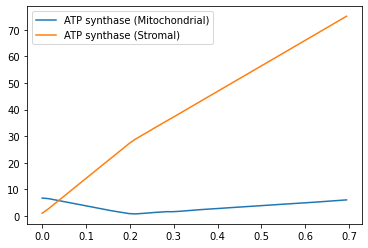

In [116]:
#Plot ATP synthase vs FDHNc activity

plt.plot(fdhnc_x, ATPSm_m, label="ATP synthase (Mitochondrial)")
plt.plot(fdhnc_x, ATPSs_m, label="ATP synthase (Stromal)")
plt.legend()
plt.show()

In [1]:

plt.plot(fdhnc_x, phloem_y, label="Phloem output")
plt.plot(fdhnc_x, no3_ex * -1, label="NO3 input")
plt.plot(fdhnc_x, co2_ex * -1, label="CO2 input")
plt.legend()
plt.show()

#Based on the plot below, It shows that CO2 input is more sensitive to FDHNc activity vs NO3 input and
#Phloem input.

NameError: name 'plt' is not defined

In [ ]:
#Formate Dehydrogenase is essential pala in generating nitrate flux due to the generation of Ubiquinone
#I'll just constrain it to use NH4 instead to prevent futile cycling.